In [1]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

raw_data = load_files(r'C:\Users\Mrinal Jain\Human-Activity-Recognition\Data', random_state=113)
files = raw_data['filenames']
targets = raw_data['target']

train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=0.25, random_state=113)

In [2]:
import numpy as np
from keras.utils import to_categorical
from utils import Videos

reader = Videos(target_size=(64, 64), max_frames=40, required_fps=5)

X_train = reader.read_videos(train_files[:200])
y_train = to_categorical(train_targets[:200], num_classes=6)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)

X_test = reader.read_videos(test_files[:100])
y_test = to_categorical(test_targets[:100], num_classes=6)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)

Using TensorFlow backend.
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.32it/s]


Shape of training data: (200, 40, 64, 64, 1)
Shape of training labels: (200, 6)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.02it/s]


Shape of testing data: (100, 40, 64, 64, 1)
Shape of testing labels: (100, 6)


In [3]:
from keras.models import Sequential
from keras.layers import LeakyReLU, Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers.core import Dense, Dropout

model = Sequential()

model.add(Conv3D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu', 
                 input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=2, padding='same'))

model.add(Conv3D(filters=32, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=2, padding='same'))

model.add(Conv3D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=2, padding='same'))

model.add(Conv3D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(GlobalAveragePooling3D())
model.add(Dropout(0.3))

model.add(Dense(6, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 40, 64, 64, 16)    448       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 32, 32, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 20, 32, 32, 32)    13856     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 10, 16, 16, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 16, 16, 64)    55360     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 8, 8, 64)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 5, 8, 8, 128)      221312    
__________

In [4]:
from keras.callbacks import ModelCheckpoint

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='CNN.weights.best.hdf5', save_best_only=True, verbose=1)
history = model.fit(X_train, y_train, batch_size=4, epochs=25, validation_split=0.2, 
                    shuffle=True, verbose=2, callbacks=[checkpoint])

Train on 160 samples, validate on 40 samples
Epoch 1/25
Epoch 00001: val_loss improved from inf to 1.72429, saving model to CNN.weights.best.hdf5
 - 11s - loss: 2.1361 - acc: 0.1437 - val_loss: 1.7243 - val_acc: 0.2750
Epoch 2/25
Epoch 00002: val_loss did not improve
 - 8s - loss: 1.7474 - acc: 0.2000 - val_loss: 1.7670 - val_acc: 0.1250
Epoch 3/25
Epoch 00003: val_loss improved from 1.72429 to 1.59949, saving model to CNN.weights.best.hdf5
 - 8s - loss: 1.6272 - acc: 0.2812 - val_loss: 1.5995 - val_acc: 0.3500
Epoch 4/25
Epoch 00004: val_loss improved from 1.59949 to 1.41501, saving model to CNN.weights.best.hdf5
 - 8s - loss: 1.5496 - acc: 0.3438 - val_loss: 1.4150 - val_acc: 0.3500
Epoch 5/25
Epoch 00005: val_loss improved from 1.41501 to 1.32233, saving model to CNN.weights.best.hdf5
 - 8s - loss: 1.4384 - acc: 0.3562 - val_loss: 1.3223 - val_acc: 0.3750
Epoch 6/25
Epoch 00006: val_loss improved from 1.32233 to 1.28305, saving model to CNN.weights.best.hdf5
 - 8s - loss: 1.3510 - a

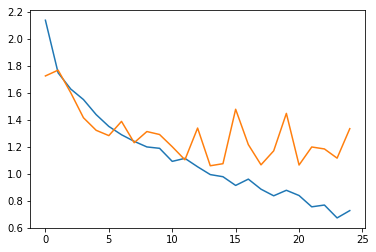

In [5]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(25)
plt.plot(epochs, loss, epochs, val_loss)

In [6]:
model.load_weights('CNN.weights.best.hdf5')
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=2, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 36.00%
